## Mono-objective Algorithms versus Random Baseline

Tool to benchmark mono-objective algorithms against a selective random algorithm that generates random solutions and stores the best it generates. Tested on datasets of 50, 100 and 200 students taken as a subset of the complete dataset while maintaining its demographic distribution.

Also executes a Wilcoxon Signed-rank test comparing the EGA and PSO's performance against each other and the random baseline respectively.

Running Large (200):   0%|          | 0/5 [00:00<?, ?it/s]

Running Large (200): 100%|██████████| 5/5 [29:03<00:00, 348.61s/it]


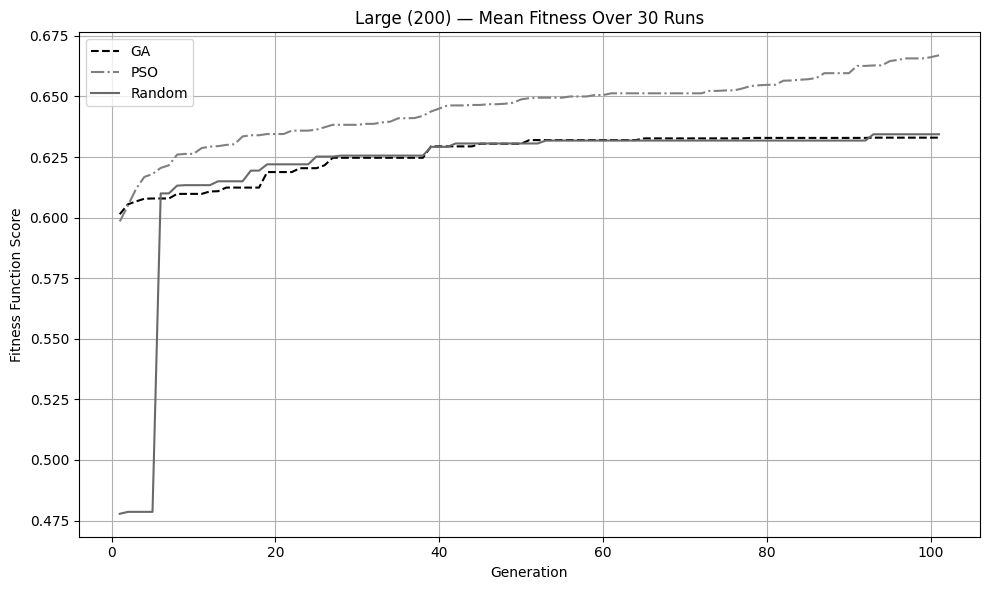


Wilcoxon Test Results:
                 PSO vs GA  PSO vs Random GA vs Random
Large (200)  (0.0, 0.0625)  (0.0, 0.0625)   (7.0, 1.0)


In [ ]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import contextlib
import io
from scipy.stats import wilcoxon
import numpy as np
import import_ipynb

import enhanced_genetic_algorithm as ega
import particle_swarm_optimization as pso
import random_baseline_algorithm as rba

RUNS = 3
DATASETS = {
    "Large (200)": "data/dataset_medium.csv",
}

wilcoxon_results = {}

for label, dataset_file in DATASETS.items():
    dataset_df = pd.read_csv(dataset_file)

    ega.DATASET = dataset_df
    pso.DATASET = dataset_df
    rba.DATASET = dataset_df

    ega_runs, pso_runs, rba_runs = [], [], []
    ega_final_scores, pso_final_scores, rba_final_scores = [], [], []

    with contextlib.redirect_stdout(io.StringIO()):
        for _ in tqdm(range(RUNS), desc=f"Running {label}"):
            timestamp = datetime.datetime.now().strftime("run_%Y%m%d_%H%M%S")

            ega.RUN_TIME = timestamp
            ega.BASE_DIR = f"output/mono_vs_random/ega/{label.lower().replace(' ', '_')}"
            df_ega, _ = ega.execute()
            ega_runs.append(df_ega["score"])
            ega_final_scores.append(df_ega["score"].iloc[-1])

            pso.RUN_TIME = timestamp
            pso.BASE_DIR = f"output/mono_vs_random/pso/{label.lower().replace(' ', '_')}"
            df_pso, _ = pso.execute()
            pso_runs.append(df_pso["score"])
            pso_final_scores.append(df_pso["score"].iloc[-1])

            rba.RUN_TIME = timestamp
            rba.BASE_DIR = f"output/mono_vs_random/rba/{label.lower().replace(' ', '_')}"
            df_rba = rba.execute()
            rba_runs.append(df_rba["score"])
            rba_final_scores.append(df_rba["score"].iloc[-1])

    # Plot average score per generation
    ega_avg = pd.concat(ega_runs, axis=1).mean(axis=1)
    pso_avg = pd.concat(pso_runs, axis=1).mean(axis=1)
    rba_avg = pd.concat(rba_runs, axis=1).mean(axis=1)
    generations = ega_avg.index.to_numpy()
    ega_avg = ega_avg.to_numpy()
    pso_avg = pso_avg.to_numpy()
    rba_avg = rba_avg.to_numpy()

    plt.figure(figsize=(10, 6))
    plt.plot(generations, ega_avg, label="GA", linestyle="--", color="black")
    plt.plot(generations, pso_avg, label="PSO", linestyle="-.", color="gray")
    plt.plot(generations, rba_avg, label="Random", linestyle="-", color="dimgray")
    plt.title(f"{label} — Mean Fitness Over 30 Runs")
    plt.xlabel("Generation")
    plt.ylabel("Fitness Function Score")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"figures/fig_average_scores_{label.lower().replace(' ', '_')}.png")
    plt.show()

    # Wilcoxon Test on final generation scores only
    try:
        stat1, pval1 = wilcoxon(pso_final_scores, ega_final_scores)
        stat2, pval2 = wilcoxon(pso_final_scores, rba_final_scores)
        stat3, pval3 = wilcoxon(ega_final_scores, rba_final_scores)

        wilcoxon_results[label] = {
            "PSO vs GA": (stat1, pval1),
            "PSO vs Random": (stat2, pval2),
            "GA vs Random": (stat3, pval3),
        }
    except Exception as e:
        wilcoxon_results[label] = {"error": str(e)}

# Print Wilcoxon Results
df_results = pd.DataFrame(wilcoxon_results).T
print("\nWilcoxon Test Results:")
print(df_results.to_string())